This experiment simulates trajectory tracking of a quadrotor for various trajectory types and settings, whilst incorporating unmodeled effects. Control is achieved by appending some Koopman model of our noise dynamics (learnt offline via eDMD) to a model of our quadrotor dynamics, and then pairing that with MPC.

# Part 1: Learn Koopman operators using eDMD

Here, we predefine a function dictionary $\psi$, use this dictionary to lift our eDMD disturbance data matrices $\textbf{W}$ and $\textbf{Y}$, and perform linear least squares regression to derive linear operators $A$, $B$, and $C$ for the following system:

\begin{equation}
\textbf{Y}_{\text{lift}} = A\textbf{W}_{\text{lift}} + B\textbf{X} + C\textbf{U} \tag{1}
\end{equation}

# Import trajectory and control data

For a single trajectory of data length $N$, our state and control data matrices are:

\begin{equation}
\textbf{X} = [x_1 \ x_2 \ x_3 \ ... \ x_N] \tag{2}
\end{equation}

\begin{equation}
\textbf{U} = [u_1 \ u_2 \ u_3 \ ... \ u_{N-1}] \tag{3}
\end{equation}

where $x_i \ \epsilon \ \mathbb{R}^{13}$ are state-space vectors of our quadrotor and $u_i \ \epsilon \ \mathbb{R}^{4}$ are control vectors. $\textbf{X}$ thus represents our trajectory data matrix and $\textbf{U}$ our control action history for that trajectory. Also, for a single trajectory, $\textbf{U}$ necessarily contains one less element than $\textbf{X}$.

Note that $\textbf{X}$ and $\textbf{U}$ are produced from `build_training_datasets.ipynb` using multiple simulated trajectories. Here, we are truncating these data matrices to only include data from a single simulated trajectory because we are uncertain about how to properly handle data sourced from multiple simulations for the purposes of learning our Koopman operators using eDMD.

Also note that in order to solve the minimization problem in Expression 10, for a single trajectory we had to truncate the last two elements of $\textbf{X}$ and the last element of $\textbf{U}$. This was done only AFTER having used these matrices to construct $\textbf{W}$, however.

In [1]:
import numpy as np
import os
import pickle

file_to_import = '02202024_05.pk1'

data_dir = os.getcwd() + '/output/training/'

with open(data_dir + file_to_import, 'rb') as pickle_file:
    data = pickle.load(pickle_file)

X = data['full_traj'].T
U = data['U'].T
indices = data['indices']

# trim matrices to included data from only one trajectory

X = X[0:indices[1][0]][:]; U = U[0:indices[1][0]][:]

# Derive disturbance data

Here, we build the disturbance data matrix:

\begin{equation}
\textbf{W} = [w_1 \ w_2 \ w_3 \ ... \ w_{N-1}] \tag{4}
\end{equation}

where $w_i \ \epsilon \ \mathbb{R}^{d}$, $d=3$. Note that $d$ equals 3 and not 13 because we have chosen to model the noise dynamics on $\dot{v}$ only (we suspect that modeling noise for $\dot{p}$ and $\dot{q}$ would be redundant). 

For a single trajectory, $\textbf{W}$ necessarily contains one less element than $\textbf{X}$. Specifically, elements of $\textbf{W}$ are derived from elements of $\textbf{X}$, $\textbf{U}$, as well as our quadrotor dynamics model $f$ as follows:

\begin{equation}
x_{k+1} = f(x_k, u_k) + w_k \implies w_k = f(x_k, u_k) - x_{k+1} \tag{5}
\end{equation}

For the purposes of eDMD, we truncate the last element of $\textbf{W}$ and create a new data matrix $\textbf{Y}$:

\begin{equation}
\textbf{W} = [w_1 \ w_2 \ w_3 \ ... \ w_{N-2}] \tag{6}
\end{equation}

\begin{equation}
\textbf{Y} = [w_2 \ w_3 \ w_4 \ ... \ w_{N-1}] \tag{7}
\end{equation}

In [2]:
from quad import Quad

# define quadrotor and world parameters

m = 1.0 # quadrotor mass in [kg]
J = np.array([.03, .03, .06]) # quadrotor moment of inertia vector in [kg⋅m⋅m]
l = 0.235 # length between motor and quadrotor CoG in [m]
c = 0.013 # torque generated by each motor in direction of quadrotor z-axis in [N⋅m]
T_max = 10 # max thrust generated by each motor in [N]
g = 9.81 # gravitational acceleration of world in [m/s/s]

quad = Quad(m=m, J=J, l=l, c=c, T_max=T_max, g=g, drag=False)

# build disturbance data matrix

W = np.zeros((X.shape[0], X.shape[1])) # disturbance data matrix
simulation_dt = 5e-4 # integration step size in [s]

for start, end in indices:
    quad.set_state(*np.split(np.array(X[start][:]), [3, 7, 10]))

    for i in range(end-start):
        quad.update(np.array(U[start+i][:]), simulation_dt)

        # compute disturbance

        x_pred = quad.get_state()
        x_act = np.array(X[start+i+1])
        W[start+i][:] = x_act - x_pred

        if i == end-start-1:
            W[start+i+1][:] = np.full((1, X.shape[1]), np.nan)

    break # to limit learning to a single simulated trajectory

# remove nan rows in noise and control data matrices

U = U[~np.isnan(U).any(axis=1)]; W = W[~np.isnan(W).any(axis=1)]

# remove superfluous entries from trajectory and control data

X = X[0:-2][:]; U = U[0:-1][:]

# construct W, Y disturbance data matrices (data shifting)

Y = W[1:,:]
W = W[:-1,:]

# perform dimensionality reduction of noise terms
    
Y = Y[:,7:10]
W = W[:,7:10]

d = W.shape[1]

# create a new matrix for dot

simulation_dt = 5e-4
W_dot= np.zeros((W.shape[0], W.shape[1]))
temp = np.append(W, Y[-1].reshape(1, -1), axis=0)
for i in range(W_dot.shape[0]):
    W_dot[i,:] = (temp[i+1,:])  / simulation_dt
    

# Define dictionary and perform lifting

We use $\psi$ to lift elements of $\textbf{W}$ and $\textbf{Y}$ to yield $\textbf{W}_{\text{lift}}$ and $\textbf{Y}_{\text{lift}}$:

\begin{equation}
\textbf{W}_{\text{lift}} = [\psi{(w_1)} \ \psi{(w_2)} \ ... \ \psi{(w_{N-2})}] \tag{8}
\end{equation}

\begin{equation}
\textbf{Y}_{\text{lift}} = [\psi{(w_2)} \ \psi{(w_3)} \ ... \ \psi{(w_{N-1})}] \tag{9}
\end{equation}

$\psi$ is our eDMD lifting dictionary. In this file, we predefine it to be some set of basis functions (e.g. monomials, radial, etc.). Note that if $\psi \ \epsilon \ \mathbb{R}^{m}$ then $\psi{(w_i)} \ \epsilon \ \mathbb{R}^{(m\times d)\times1}$.

In [3]:
from dictionary import Monomial

dictionary_type = "monomial"
dictionary_size = 3

Ψ = Monomial(m=dictionary_size-1)
W_lift = Ψ.forward(W)
Y_lift = Ψ.forward(Y)
W_dot_lift = Ψ.forward(W_dot)

# formally define dimension of lifted state and perform assertions

M = d * (Ψ.m + 1)

assert W_lift.shape[1] == M
assert Y_lift.shape[1] == M

# Perform least squares regression

 Referring to Equation 1, the eDMD algorithm finds optimum $A$, $B$, and $C$ by solving the following minimization problem using (multivariate) least-squares regression:

\begin{equation}
\min_{A,B,C}||\textbf{Y}_{\text{lift}} - A\textbf{W}_{\text{lift}} - B\textbf{X} - C\textbf{U}||_\textit{F} \tag{10}
\end{equation}

It can be shown that the closed-form solution to this problem is:

\begin{equation}
[A,B,C] = (\textbf{G}^T\textbf{G})^{-1}\textbf{G}^T\textbf{Y}_{\text{lift}} \tag{11}
\end{equation}

where $\textbf{G} = [\textbf{Y}_{\text{lift}} \ \ \textbf{X} \ \ \textbf{U}]$. We are unsure whether or not Expression 10 can be shown to be convex.

It is now clear that what we are learning is a lifted linear representation of our noise dynamics (i.e. a linear disturbance model). This model will be leveraged in Part 2 when we pair it with MPC.

Note that we define a matrix $\psi^{-1}$ here, which we'll call our inversion matrix. The function of the inversion matrix is as follows: take $z_{k}$ to be a single element of $\textbf{W}$ lifted using $\psi$. Thus, $z_{k+1} = \psi(w_{k+1})$. We can thus write:

\begin{equation}
z_{k+1} = \psi(w_{k+1}) = Az_k + Bx_k + Cu_k \implies w_{k+1} = \psi^{-1}(Az_k + Bx_k + Cu_k) \tag{12}
\end{equation}

The need for expressing our noise model using a state-space rather than lifted-space formulation is because when pairing this model with MPC for control, we require that we append it to our quadrotor dynamics model $f(x_k, u_k)$ (see Equation 5), which is itself formulated in state-space. But what is $\psi^{-1}$, exactly? ...

Continuous time representation?

In [4]:
# # create a new matrix for dot

# simulation_dt = 5e-4
# W_dot= np.zeros((W_lift.shape[0], W_lift.shape[1])) #
# temp = np.append(W_lift, Y_lift[-1].reshape(1, -1), axis=0)
# for i in range(W_dot.shape[0]):
#     W_dot[i,:] = (temp[i+1,:] - temp[i,:])  / simulation_dt
    
# define additional information for dimensionality

L = 13 # dimension of states-space vector
K = 4 # dimension of control vector

S = Y.shape[1] # dimension of truncated (so not 13 but now 6)

# perform least squares regression

G = np.hstack((W_lift, X, U))
pinv = np.linalg.pinv(G)
# res = pinv.dot(Y_lift)
res = pinv.dot(W_dot_lift)

# extract Koopman matrices

A = res[0:M, :]
B = res[M:M+L, :]; B = B.T
C = res[M+L:, :]; C = C.T

# define inversion matrix (generalize)

Ψ_inv = np.eye(W_lift.shape[1])[S:S*2]

# Part 2: Trajectory tracking using Koopman-MPC

Here, we append our learned Koopman model of our noise dynamics $g(z_k, x_k, u_k)$ to a model of our quadrotor dynamics $f(x_k, u_k)$, and then pair this appended model with MPC to achieve control. Our control objective is trajectory tracking of some reference trajectory.

# Configure settings

Note that we are required to use the same quadrotor properties (e.g. mass, max thrust, etc.) as before when building our disturbance data matrix. 

In [5]:
import numpy as np

# toggle simulation disturbances

simulation_disturbances = {
    "drag": True,
}
    
# define quadrotor and world properties

init_pos = np.array([0.0, 1.0, 1.0]) # initial position of quadrotor

# define drag coefficients

rotor_drag = np.array([0.3, 0.3, 0.0])[:, np.newaxis] # rotor drag coefficients in [kg/m]
aero_drag = 0.08 # aerodynamic drag coefficient in [kg/m]

# define MPC and RK4 settings

t_horizon = 1.0 # prediction horizon in [s]
n_mpc_nodes = 10 # number of control nodes within horizon [?]
Q = np.array([10, 10, 10, 0.1, 0.1, 0.1, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]) # weighing matrix for quadratic cost function
R = np.array([0.1, 0.1, 0.1, 0.1]) # weighing matrix for quadratic cost function
simulation_dt = 5e-4 # integration step size in [s]

# define trajectory settings

traj_radius = 5 # radius of trajectory in [m]
traj_v_max = 16 # maximum speed at peak velocity in [m/s]
traj_a_lin = 1 # linear acceleration of trajectory in [m/s/s]
reference_over_sampling = 5

# toggle plotting features

animate_plots = False

# Generate reference trajectory

Please export ACADOS_SOURCE_DIR to avoid this warning.
 If there is an incompatibility with the CasADi generated code, please consider changing your CasADi version.
Version 3.6.5 currently in use.
Please export ACADOS_SOURCE_DIR to avoid this warning.
Please export ACADOS_SOURCE_DIR to avoid this warning.
Please export ACADOS_SOURCE_DIR to avoid this warning.
Please export ACADOS_SOURCE_DIR to avoid this warning.
Please export ACADOS_SOURCE_DIR to avoid this warning.
Please export ACADOS_SOURCE_DIR to avoid this warning.
Please export ACADOS_SOURCE_DIR to avoid this warning.
Please export ACADOS_SOURCE_DIR to avoid this warning.
Please export ACADOS_SOURCE_DIR to avoid this warning.
Please export ACADOS_SOURCE_DIR to avoid this warning.
Please export ACADOS_SOURCE_DIR to avoid this warning.
Please export ACADOS_SOURCE_DIR to avoid this warning.
Please export ACADOS_SOURCE_DIR to avoid this warning.
Please export ACADOS_SOURCE_DIR to avoid this warning.
Please export ACADOS_SOURCE_DIR t

ld: warning: directory not found for option '-L-l'


acados was compiled without OpenMP.


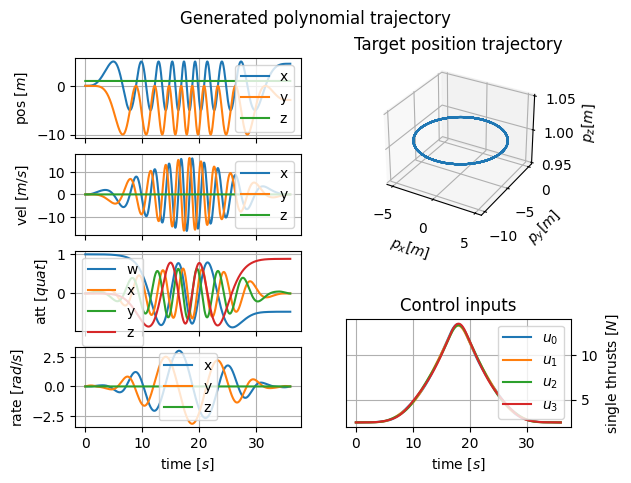

In [6]:
import sys

from quad import Quad
from quad_mpc_koopman_scheme_A import QuadMPCKoopmanSchemeA
from trajectories import check_trajectory, loop_trajectory

# instantiate Quad and QuadMPC objects

quad = Quad(m=m, J=J, l=l, c=c, T_max=T_max, g=g, rotor_drag=rotor_drag, aero_drag=aero_drag, drag=simulation_disturbances["drag"])
quad_mpc = QuadMPCKoopmanSchemeA(quad=quad, t_horizon=t_horizon, n_nodes=n_mpc_nodes, Q=Q, R=R, 
                                  A=A, B=B, C=C, Ψ_inv=Ψ_inv, lifted_state_dim=M)

# generate reference trajectory and control policy (burrowed entirely from https://github.com/uzh-rpg/data_driven_mpc/tree/main)

control_period = t_horizon / (n_mpc_nodes * reference_over_sampling) # sampling period of trajectory

reference_traj, reference_timestamps, reference_u = loop_trajectory(
    quad=quad, discretization_dt=control_period, radius=traj_radius, 
    lin_acc=traj_a_lin, clockwise=True, yawing=False, v_max=traj_v_max, plot=True)

if not check_trajectory(reference_traj, reference_timestamps, plot=False):
    print("Reference trajectory integrity check failed!")
    sys.exit(1)

# compute reference speed

reference_speed = np.linalg.norm(reference_traj[:,7:10], axis=1)

# Perform simulation

In [7]:
from utils.math import separate_variables
from utils.mpc import get_reference_chunk

# initialize quadrotor state

initial_state = np.split(reference_traj[0, :], [3, 7, 10])
initial_state[0] = init_pos
quad.set_state(*initial_state)

n_quad_states = len(quad.get_state())
n_control_states = len(quad.u)

# begin simulation

quad_traj = np.zeros([len(reference_timestamps), n_quad_states]) # store quadrotor trajectory
opt_u = reference_u[0, :] # optimal control action to be applied in MPC loop
opt_u_history = np.zeros([len(reference_timestamps), n_control_states]) # store optimal control action history
tracking_error = np.zeros(len(reference_timestamps)) # store tracking error

print("\nRunning MPC loop ...")

for i in range(len(reference_timestamps)):
    
    # retrieve and save quadrotor state

    quad_current_state = quad.get_state()
    quad_traj[i, :] = np.expand_dims(quad_current_state, axis=0)

    # compute tracking error

    tracking_error[i] = np.linalg.norm(reference_traj[i, :3] - quad_traj[i, :3])

    # get the chunk of trajectory required for the current optimization (burrowed entirely from https://github.com/uzh-rpg/data_driven_mpc/tree/main)

    ref_traj_chunk, ref_u_chunk = get_reference_chunk(reference_traj, reference_u, i, n_mpc_nodes, reference_over_sampling)

    # set the reference for the OCP
    
    quad_mpc.set_reference(x_ref=separate_variables(ref_traj_chunk), u_ref=ref_u_chunk)

    # solve OCP to retrieve optimized control and state sequences
    
    u_opt_acados, x_opt_acados = quad_mpc.optimize()

    # select first set of control actions as the control to apply to the plant

    opt_u = u_opt_acados[:4]
    opt_u_history[i, :] = np.reshape(opt_u, (1, -1)) # why is 'np.reshape' needed here?
    
    # apply control action to quadrotor and update state

    simulation_time = 0.0
    while simulation_time < control_period:
        quad.update(opt_u, simulation_dt)
        simulation_time += simulation_dt

quad_current_state = quad.get_state()
quad_traj[-1, :] = np.expand_dims(quad_current_state, axis=0)

# compute tracking RMSE

tracking_rmse = np.mean(np.sqrt(np.sum((reference_traj[:, :3] - quad_traj[:, :3]) ** 2, axis=1)))


Running MPC loop ...

SQP_RTI: QP solver returned error status 3 QP iteration 1.

SQP_RTI: QP solver returned error status 3 QP iteration 1.

SQP_RTI: QP solver returned error status 3 QP iteration 1.

SQP_RTI: QP solver returned error status 3 QP iteration 1.

SQP_RTI: QP solver returned error status 3 QP iteration 1.

SQP_RTI: QP solver returned error status 3 QP iteration 1.

SQP_RTI: QP solver returned error status 3 QP iteration 1.

SQP_RTI: QP solver returned error status 3 QP iteration 1.

SQP_RTI: QP solver returned error status 3 QP iteration 1.

SQP_RTI: QP solver returned error status 3 QP iteration 1.

SQP_RTI: QP solver returned error status 3 QP iteration 1.

SQP_RTI: QP solver returned error status 3 QP iteration 1.

SQP_RTI: QP solver returned error status 3 QP iteration 1.

SQP_RTI: QP solver returned error status 3 QP iteration 1.

SQP_RTI: QP solver returned error status 3 QP iteration 1.

SQP_RTI: QP solver returned error status 3 QP iteration 1.

SQP_RTI: QP solve


::::::::::::: SIMULATION RESULTS :::::::::::::

Final tracking RMSE: 191.0582 m



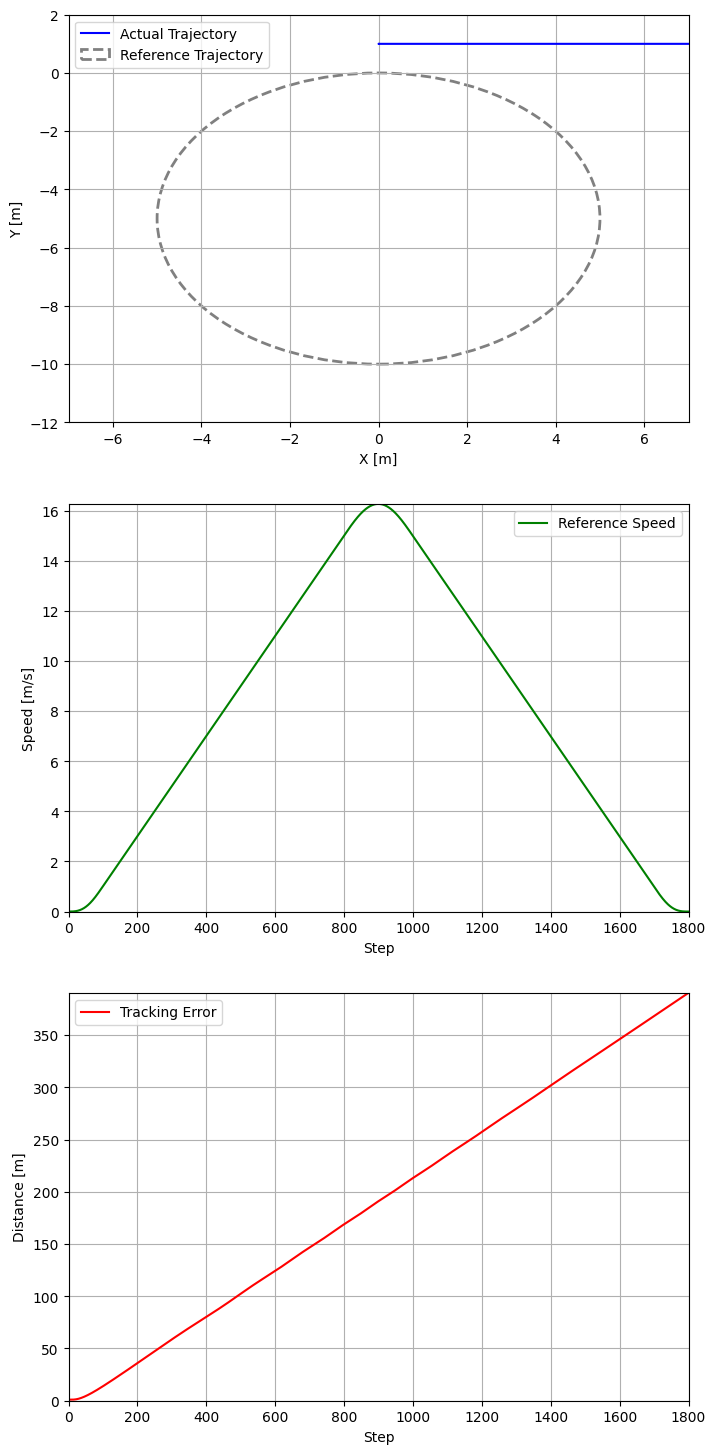

In [8]:
import matplotlib.pyplot as plt

from datetime import datetime
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
from scipy import io

print("\n::::::::::::: SIMULATION RESULTS :::::::::::::\n")
print("Final tracking RMSE: %.4f m\n" % tracking_rmse)

fig, axs = plt.subplots(3, 1, figsize=(8, 18))

axs[0].set_xlim(-7, 7); axs[0].set_ylim(-12, 2)
axs[0].set_xlabel('X [m]'); axs[0].set_ylabel('Y [m]')
axs[0].grid(True)
line_traj, = axs[0].plot([], [], color='blue', label='Actual Trajectory')
circle = plt.Circle((0, -traj_radius), radius=traj_radius, color='gray', fill=False, linestyle='dashed', linewidth=2, label='Reference Trajectory')
axs[0].add_patch(circle)

axs[1].set_xlim(0, len(reference_timestamps)); axs[1].set_ylim(0, max(reference_speed))
axs[1].set_xlabel('Step'); axs[1].set_ylabel('Speed [m/s]')
axs[1].grid(True)
line_speed, = axs[1].plot([], [], color='green', label='Reference Speed')

axs[2].set_xlim(0, len(reference_timestamps)); axs[2].set_ylim(0, max(tracking_error))
axs[2].set_xlabel('Step'); axs[2].set_ylabel('Distance [m]')
axs[2].grid(True)
line_error, = axs[2].plot([], [], color='red', label='Tracking Error')

def init():
    line_traj.set_data([], []); line_speed.set_data([], []); line_error.set_data([], [])
    return line_traj, line_speed, line_error, circle

def animate(t):
    x_traj = quad_traj[:t, 0]; y_traj = quad_traj[:t, 1]
    line_traj.set_data(x_traj, y_traj)

    time = np.arange(t); speed = reference_speed[:t]
    line_speed.set_data(time, speed)
        
    error = tracking_error[:t]
    line_error.set_data(time, error)
        
    return line_traj, line_speed, line_error, circle

if animate_plots:
    plt.rcParams['animation.embed_limit'] = 150.0
    animation = FuncAnimation(fig, animate, frames=len(reference_timestamps), init_func=init, interval=1, blit=True)
else:
    line_traj, = axs[0].plot(quad_traj[:,0], quad_traj[:,1], color='blue')
    line_speed, = axs[1].plot(np.arange(len(reference_timestamps)), reference_speed, color='green')
    line_error, = axs[2].plot(np.arange(len(reference_timestamps)), tracking_error, color='red')

axs[0].legend()
axs[1].legend()
axs[2].legend()

if animate_plots:
    animation.save('animation_drag.gif', writer='pillow', fps=30)
    HTML(animation.to_jshtml())

# save plot file

data_dir = os.getcwd() + '/output/plots/'
current_date = datetime.now().strftime('%m%d%Y')

def get_next_index(file_prefix, extension):
    index = 0
    while True:
        file_name = f'{file_prefix}_{index:02d}.{extension}'

        try:
            with open(file_name, 'rb'):
                index += 1
        except FileNotFoundError:
            break

    return index

file_prefix = data_dir + current_date + '_' + dictionary_type + '_' + 'm=' + str(dictionary_size)
extension = 'png'

index = get_next_index(file_prefix, extension)

file_name = f'{file_prefix}_{index:02d}.{extension}'

plt.savefig(file_name)

# save metadata

metadata = {
    'simulation_name': file_prefix,
    'simulation_settings': {
        'dictionary_type': dictionary_type,
        'dictionary_size': dictionary_size,
        'disturbances': simulation_disturbances,
        'm': m,
        'J': J,
        'l': l,
        'c': c,
        'T_max': T_max,
        'g': g,
        'init_pos': init_pos,
        'rotor_drag': rotor_drag,
        'aero_drag': aero_drag,
        't_horizon': t_horizon,
        'n_mpc_nodes': n_mpc_nodes,
        'Q': Q,
        'R': R,
        'simulation_dt': simulation_dt,
        'traj_radius': traj_radius,
        'traj_v_max': traj_v_max,
        'traj_a_lin': traj_a_lin,
        'reference_over_sampling': reference_over_sampling,
        'tracking_rmse': tracking_rmse,
    }
}

data_dir = os.getcwd() + '/output/metadata/'
current_date = datetime.now().strftime('%m%d%Y')

file_prefix = data_dir + current_date + '_' + dictionary_type + '_' + 'm=' + str(dictionary_size)
extension = 'mat'

index = get_next_index(file_prefix, extension)

file_name = f'{file_prefix}_{index:02d}.{extension}'

io.savemat(file_name, metadata)